<a href="https://colab.research.google.com/github/PragsGit/Movie-Recommender/blob/Content_Based_Recommender/Content_Based_Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q tensorflow

In [4]:
# Import libraries
from urllib.request import urlretrieve
import zipfile
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, find
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
# Read MovieLens 20M Dataset
urlretrieve('https://files.grouplens.org/datasets/movielens/ml-20m.zip', 'movielens')
zip_ref = zipfile.ZipFile('movielens', 'r')
zip_ref.extractall()
zip_ref.printdir()

File Name                                             Modified             Size
ml-20m/                                        2016-10-17 10:12:54            0
ml-20m/genome-scores.csv                       2016-10-17 09:41:10    323544381
ml-20m/genome-tags.csv                         2016-10-17 09:41:10        18103
ml-20m/links.csv                               2016-10-17 09:50:40       570090
ml-20m/movies.csv                              2015-03-31 16:17:54      1397542
ml-20m/ratings.csv                             2015-03-31 16:14:02    533444411
ml-20m/README.txt                              2016-10-17 10:21:00        10261
ml-20m/tags.csv                                2015-03-31 16:01:38     16603996


In [6]:
print(zip_ref.read('ml-20m/genome-tags.csv'))

b"tagId,tag\r\n1,007\r\n2,007 (series)\r\n3,18th century\r\n4,1920s\r\n5,1930s\r\n6,1950s\r\n7,1960s\r\n8,1970s\r\n9,1980s\r\n10,19th century\r\n11,3d\r\n12,70mm\r\n13,80s\r\n14,9/11\r\n15,aardman\r\n16,aardman studios\r\n17,abortion\r\n18,absurd\r\n19,action\r\n20,action packed\r\n21,adaptation\r\n22,adapted from:book\r\n23,adapted from:comic\r\n24,adapted from:game\r\n25,addiction\r\n26,adolescence\r\n27,adoption\r\n28,adultery\r\n29,adventure\r\n30,affectionate\r\n31,afi 100\r\n32,afi 100 (laughs)\r\n33,afi 100 (movie quotes)\r\n34,africa\r\n35,afterlife\r\n36,aging\r\n37,aids\r\n38,airplane\r\n39,airport\r\n40,alaska\r\n41,alcatraz\r\n42,alcoholism\r\n43,alien\r\n44,alien invasion\r\n45,aliens\r\n46,allegory\r\n47,almodovar\r\n48,alone in the world\r\n49,alter ego\r\n50,alternate endings\r\n51,alternate history\r\n52,alternate reality\r\n53,alternate universe\r\n54,amazing cinematography\r\n55,amazing photography\r\n56,american civil war\r\n57,amnesia\r\n58,amy smart\r\n59,android(

In [7]:
# Read genome-tags
genome_tags = pd.read_csv('ml-20m/genome-tags.csv')
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [8]:
# Read genome-scores
genome_scores = pd.read_csv('ml-20m/genome-scores.csv')
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [9]:
# Join genome-scores and genome-tags
genome = pd.merge(genome_scores, genome_tags, on = ['tagId'], how = 'left')
genome.head()

,movieId,tagId,relevance,tag
0,1,1,0.02500,007
1,1,2,0.02500,007 (series)
2,1,3,0.05775,18th century
3,1,4,0.09675,1920s
4,1,5,0.14675,1930s


In [10]:
genome_relevant = genome[genome['relevance'] > 0.5]
genome_relevant.head()

,movieId,tagId,relevance,tag
10,1,11,0.57700,3d
18,1,19,0.67050,action
28,1,29,0.89200,adventure
29,1,30,0.67625,affectionate
60,1,61,0.54475,animal movie


In [11]:
# Create corpus for tags with high relevance
movie_tags_corpus = genome_relevant.groupby('movieId').tag.agg([('tag', ' '.join)]).reset_index()

In [12]:
movie_tags_corpus.head()

,movieId,tag
0,1,3d action adventure affectionate animal movie ...
1,2,action adapted from:book adventure animal movi...
2,3,chase comedy crappy sequel destiny family fish...
3,4,adultery betrayal chick flick divorce feel goo...
4,5,catastrophe chase comedy crappy sequel culture...


In [13]:
movie_tags_corpus.shape

(10381, 2)

In [14]:
vectorizer = TfidfVectorizer(min_df=0.0001, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(movie_tags_corpus['tag'])

In [15]:
tfidf_matrix.sort_indices()

In [16]:
# Convert CSR matrix to Tensor
idx, idy, val = find(tfidf_matrix)
idx = tf.cast(idx, tf.int64)
idy = tf.cast(idy, tf.int64)
# merge idx and idy matrices to get [idx, idy]
full_indices = tf.stack([idx, idy], axis = 1)
# output matrix size
depth_x = tfidf_matrix.shape[0]
depth_y = tfidf_matrix.shape[1]
# Sparse to dense matrix
dense = tf.SparseTensor(full_indices, val, dense_shape=[depth_x, depth_y])
dense = tf.sparse.reorder(dense)
dense = tf.sparse.to_dense(dense)

In [17]:
# Split into train and test data
train_dim = int(round(0.7*depth_x, 0))
test_dim = int(round(0.3*depth_x, 0))
train, test = tf.split(dense, [train_dim, test_dim], axis = 0)

In [18]:
# Define autoencoder
latent_dim = 100

input_dim = Input(shape = (depth_y, ))

# Encoder layer
encoded = Dense(latent_dim, activation='relu')(input_dim)

# Decoder layer
decoded = Dense(depth_y, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(inputs = input_dim, outputs = decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [19]:
# Fit the model
history = autoencoder.fit(train, train,
                epochs=10,
                shuffle=True,
                validation_data=(test, test))

Epoch 1/10
228/228 [==============================] - 4s 13ms/step - loss: 0.0402 - val_loss: 0.0013
Epoch 2/10
228/228 [==============================] - 2s 7ms/step - loss: 0.0012 - val_loss: 9.8066e-04
Epoch 3/10
228/228 [==============================] - 1s 6ms/step - loss: 9.7593e-04 - val_loss: 9.1765e-04
Epoch 4/10
228/228 [==============================] - 2s 7ms/step - loss: 9.1982e-04 - val_loss: 8.9374e-04
Epoch 5/10
228/228 [==============================] - 1s 6ms/step - loss: 8.9557e-04 - val_loss: 8.8228e-04
Epoch 6/10
228/228 [==============================] - 1s 6ms/step - loss: 8.8269e-04 - val_loss: 8.7576e-04
Epoch 7/10
228/228 [==============================] - 1s 6ms/step - loss: 8.7487e-04 - val_loss: 8.7148e-04
Epoch 8/10
228/228 [==============================] - 1s 6ms/step - loss: 8.6959e-04 - val_loss: 8.6885e-04
Epoch 9/10
228/228 [==============================] - 1s 6ms/step - loss: 8.6567e-04 - val_loss: 8.6630e-04
Epoch 10/10
228/228 [==================

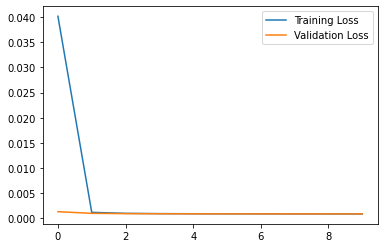

In [20]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [21]:
# Create encoder model
encoder = Model(inputs = input_dim, outputs = encoded)

In [22]:
# Use encoder to reduce dimension of train and test data
encoded_train = pd.DataFrame(encoder.predict(train))
encoded_test = pd.DataFrame(encoder.predict(test))

98/98 [==============================] - 0s 2ms/step


In [23]:
tag_encoding = pd.concat([encoded_train, encoded_test]).reset_index(drop=True)

In [28]:
tag_encoding.shape

(10381, 100)

In [29]:
tag_encoding = pd.concat([movie_tags_corpus['movieId'], tag_encoding], axis = 1)
tag_encoding.head()

,movieId,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1,0.721951,0.802446,0.677135,0.640085,0.741355,0.703988,0.727172,0.676550,0.705780,...,0.674212,0.786089,0.698519,0.739599,0.703063,0.713363,0.645415,0.706609,0.678924,0.799287
1,2,0.618761,0.546813,0.547869,0.562761,0.533414,0.603025,0.567117,0.582648,0.568923,...,0.634170,0.606112,0.578105,0.600285,0.671519,0.592439,0.612280,0.602071,0.627061,0.629447
2,3,0.438988,0.488383,0.443470,0.425818,0.394795,0.472824,0.517201,0.380497,0.473724,...,0.474126,0.420765,0.437470,0.479416,0.474575,0.413752,0.359129,0.459471,0.437688,0.489110
3,4,0.485147,0.504772,0.493864,0.432087,0.453450,0.510699,0.508400,0.444512,0.515987,...,0.462323,0.544662,0.495490,0.501598,0.545128,0.534377,0.460054,0.485131,0.502638,0.596753
4,5,0.535936,0.612600,0.605063,0.465639,0.542584,0.621085,0.565138,0.524929,0.552128,...,0.588207,0.566015,0.601435,0.628827,0.622109,0.534738,0.543118,0.590888,0.560023,0.637932


In [31]:
# Read ratings data
ratings = pd.read_csv('ml-20m/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [25]:
# Read movie data
movies = pd.read_csv('ml-20m/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [119]:
# Join movie and ratings data
# ratings = ratings.set_index(['movieId'])
# movies = movies.set_index(['movieId'])
movie_ratings = movies.join(ratings, how = 'left', on = ['movieId']).reset_index()
movie_ratings = movie_ratings.groupby(['movieId', 'title', 'genres']).agg(ratings_count = ('rating', 'count'), avg_rating = ('rating', 'mean')).reset_index()
movie_ratings = movie_ratings.set_index('movieId')
movie_ratings.head()

,title,genres,ratings_count,avg_rating
movieId,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,49695,3.921240
2,Jumanji (1995),Adventure|Children|Fantasy,22243,3.211977
3,Grumpier Old Men (1995),Comedy|Romance,12735,3.151040
4,Waiting to Exhale (1995),Comedy|Drama|Romance,2756,2.861393
5,Father of the Bride Part II (1995),Comedy,12161,3.064592


In [141]:
movie_ratings[movie_ratings['title'].str.contains('Kill Bill')]

,title,genres,ratings_count,avg_rating
movieId,,,,
6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,21746,3.901338
7438,Kill Bill: Vol. 2 (2004),Action|Drama|Thriller,18684,3.869086


In [111]:
# Cosine similarity to find similar movies
encodings = tag_encoding.iloc[:,1:].values
cossim = cosine_similarity(encodings)
cossim_df = pd.DataFrame(cossim)
sim_df_all = pd.concat([tag_encoding['movieId'], cossim_df], axis = 1).set_index('movieId')

In [138]:
def get_similar_movies(movie):
  if movie < len(sim_df_all)-1:
    print(movie)
    sim_df = pd.DataFrame(sim_df_all.loc[sim_df_all.index == movie].values.reshape([10381, 1]), columns = ['similarity_score'])
    sim_df = pd.concat([tag_encoding['movieId'], sim_df], axis = 1).set_index('movieId')
    similar_movies = movie_ratings.join(sim_df, how = 'left', on = 'movieId').sort_values(by = ['similarity_score'], ascending = False)
    similar_movies = similar_movies.iloc[1:22, :]
    movie_name = movie_ratings.loc[movie_ratings.index == movie, 'title'].values
    
  else:
    print('No similar movie found')

In [144]:
get_similar_movies(7438)

7438
Movies similar to ['Kill Bill: Vol. 2 (2004)'] are : 
                                                      title  \
movieId                                                      
6874                              Kill Bill: Vol. 1 (2003)   
1089                                 Reservoir Dogs (1992)   
296                                    Pulp Fiction (1994)   
110501                         The Raid 2: Berandal (2014)   
86142           13 Assassins (Jûsan-nin no shikaku) (2010)   
38095       Bittersweet Life, A (Dalkomhan insaeng) (2005)   
3030                                        Yojimbo (1961)   
2959                                     Fight Club (1999)   
99114                              Django Unchained (2012)   
44665                           Lucky Number Slevin (2006)   
1729                                   Jackie Brown (1997)   
2542              Lock, Stock & Two Smoking Barrels (1998)   
6                                              Heat (1995)   
858       

In [76]:
a = tag_encoding.values
type(a)

numpy.ndarray

In [95]:
norma = norm(a)

In [99]:
encodings.shape

(10381, 100)

array([[0.99999994, 0.9968145 , 0.9929651 , ..., 0.9947523 , 0.9960665 ,
        0.9970524 ],
       [0.9968145 , 1.        , 0.9938501 , ..., 0.9947835 , 0.99528974,
        0.99580324],
       [0.9929651 , 0.9938501 , 0.9999997 , ..., 0.9916901 , 0.9923448 ,
        0.9934424 ],
       ...,
       [0.9947523 , 0.9947835 , 0.9916901 , ..., 1.        , 0.9943621 ,
        0.99426633],
       [0.9960665 , 0.99528974, 0.9923448 , ..., 0.9943621 , 0.99999946,
        0.9970404 ],
       [0.9970524 , 0.99580324, 0.9934424 , ..., 0.99426633, 0.9970404 ,
        1.0000001 ]], dtype=float32)